In [1]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output

In [1]:
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from skimage import exposure
from matplotlib.patches import Polygon
from RSData import *
from HaiYangData import *
from tensorflow_examples.models.pix2pix import pix2pix

import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import cv2
import io
import shapefile


In [10]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# 读取数据

In [24]:
image_dir = r'E:\\python_workfile\\sea_ice_classification\\training\\data\\'
mask_dir = r'E:\\python_workfile\\sea_ice_classification\\training\\mask\\'

In [23]:
import random
import glob
image_paths = list(glob.glob(image_dir + '*.png'))
mask_paths = list(glob.glob(mask_dir + '*.png'))
training_path = [[image,mask]for image,mask in zip(image_paths,mask_paths)]
random.shuffle(training_path)
image_count = len(training_path)
# image_count

In [25]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [44]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (1620, 1620))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (1620, 1620))
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [26]:
TRAIN_LENGTH = image_count
BATCH_SIZE = 2
BUFFER_SIZE = 2
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [50]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(load_and_preprocess_image(display_list[i]))
        plt.axis('off')
    plt.show()

In [46]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [1620, 1620])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

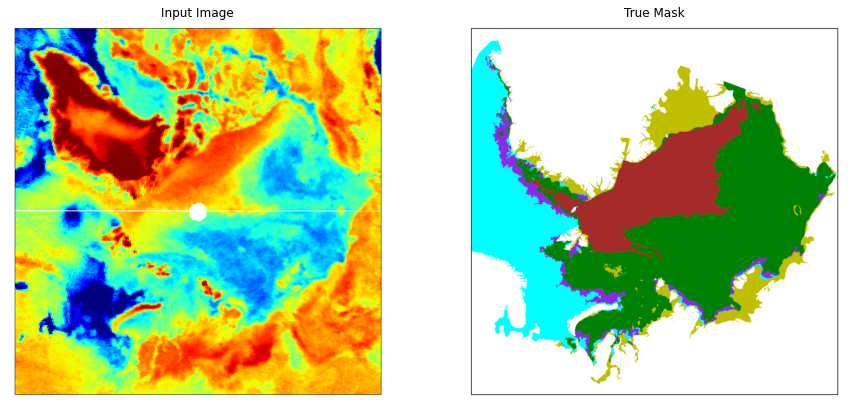

In [51]:
sample_image, sample_mask = training_path[0]
display([sample_image, sample_mask])

In [49]:
OUTPUT_CHANNELS = 3

'E:\\\\python_workfile\\\\sea_ice_classification\\\\training\\\\mask\\20200505.png'

In [52]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[1620, 1620, 3], include_top=False)

# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 8s 1us/step
